In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import geoopt
import torch

In [3]:
from embedders.manifolds import Manifold, ProductManifold

In [4]:
m_h = Manifold(-1, 4)
m_h.sample([[1, 0, 0, 0, 0] * 3])

tensor([[ 3.8326e+00,  5.1457e-01,  1.8666e+00, -3.1527e+00,  5.8332e-04],
        [ 1.1413e+01, -2.8058e+00,  6.9002e+00,  7.5448e+00,  4.1043e+00],
        [ 2.3229e+00, -1.3404e+00, -3.0592e-03,  5.5903e-01, -1.5122e+00]],
       grad_fn=<CatBackward0>)

In [5]:
m_e = Manifold(0, 4)
m_e.sample([[1, 0, 0, 0] * 3])

tensor([[ 1.4975,  0.3814,  0.8207, -0.2566],
        [ 3.1602, -0.1947,  0.6192, -0.1123],
        [ 1.3727, -0.2575, -0.9854,  0.0577]], grad_fn=<AddBackward0>)

In [6]:
m_s = Manifold(1, 4)
m_s.sample([[1, 0, 0, 0, 0] * 4])

tensor([[-0.5554,  0.2213,  0.3714,  0.3680, -0.6076],
        [ 0.6272, -0.0065, -0.0015,  0.7668,  0.1362],
        [ 0.3036, -0.1562,  0.3634, -0.0785,  0.8632],
        [ 0.0915, -0.0921, -0.2514,  0.9522, -0.1152]],
       grad_fn=<WhereBackward0>)

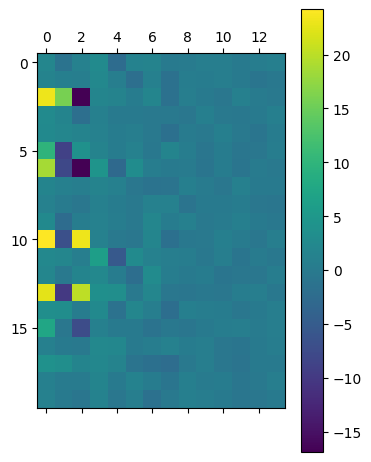

In [7]:
import matplotlib.pyplot as plt

signature = [(-2, 2), (-1, 2), (0, 2), (1, 2), (2, 2)]
pm = ProductManifold(signature)

z_sample = pm.sample([1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0] * 20)

plt.matshow(z_sample.detach().numpy().reshape(20, 14))
plt.colorbar()
plt.show()

-2
-1.0
-0.5
0
0.5
1.0
2.0


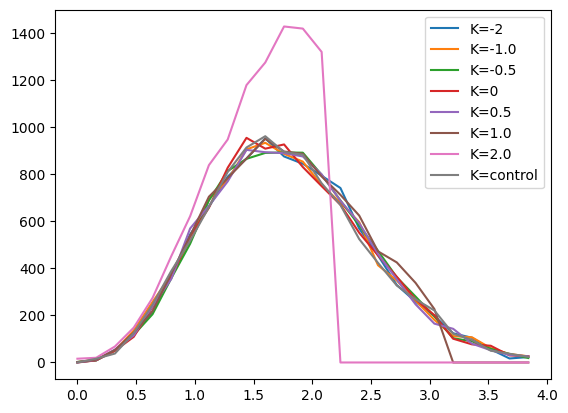

In [8]:
# Sanity check: can we get the right distribution of samples for different scales?

N_SAMPLES = 10_000

all_dists = {}
for K in [-2, -1.0, -0.5, 0, 0.5, 1.0, 2.0]:
    print(K)
    m = Manifold(K, 4)
    samples = m.sample(torch.cat([m.mu0] * N_SAMPLES, dim=0))
    dists = m.dist(m.mu0, samples)
    all_dists[K] = dists

all_dists["control"] = torch.norm(torch.randn(size=(N_SAMPLES, 4)), dim=1)

# Get histograms with torch and line-plot them
for K, dists in all_dists.items():
    dist_hist = torch.histogram(dists, bins=25, range=(0, 4))
    plt.plot(dist_hist.bin_edges[:-1].detach().cpu().numpy(), dist_hist.hist.detach().cpu().numpy(), label=f"K={K}")
plt.legend()

# Great, this looks right: all distances match, except where we totally run out of space on our manifold
# (e.g. K=2; K=1 is starting to curve off a little bit near d=pi...)

In [99]:
# Verify that log-likelihood functions work:

for K in [-2, -1.0, -0.5, 0, 0.5, 1.0, 2.0]:
    print(K)
    m = Manifold(K, 4)
    # Pick a random point to use as the center
    mu = m.sample(m.mu0)
    Sigma = torch.diag(torch.randn(4))**2
    samples = m.sample(z_mean = torch.cat([mu] * N_SAMPLES, dim=0), sigma=Sigma)
    log_probs_p = m.log_likelihood(z=samples) # Default args
    log_probs_q = m.log_likelihood(z=samples, mu=mu, sigma=Sigma)
    print(f"Shape: {log_probs_p.shape},\tP(z) = {log_probs_p.mean().item():.3f},\tQ(z) = {log_probs_q.mean().item():.3f},\tQ(z) - P(z) = {log_probs_q.mean().item() - log_probs_p.mean().item():.3f}")
    print()

    # Why don't we generally see Q(z) - P(z) > 0? I would think the ll of the true distribution would be higher than the ll of the wrong distribution...

-2
Shape: torch.Size([10000]),	P(z) = -12.832,	Q(z) = -5.810,	Q(z) - P(z) = 7.023

-1.0
Shape: torch.Size([10000]),	P(z) = -11.210,	Q(z) = -7.280,	Q(z) - P(z) = 3.930

-0.5
Shape: torch.Size([10000]),	P(z) = -8.188,	Q(z) = 0.663,	Q(z) - P(z) = 8.852

0
Shape: torch.Size([10000]),	P(z) = -10.687,	Q(z) = -5.893,	Q(z) - P(z) = 4.794

0.5
Shape: torch.Size([10000]),	P(z) = -4.783,	Q(z) = -4.162,	Q(z) - P(z) = 0.621

1.0
Shape: torch.Size([10000]),	P(z) = -3.559,	Q(z) = -2.726,	Q(z) - P(z) = 0.833

2.0
Shape: torch.Size([10000]),	P(z) = -2.899,	Q(z) = -0.250,	Q(z) - P(z) = 2.649

